## IMPORTS

In [1]:
import os
import pandas as pd
import numpy as np
import csv
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import tqdm
import ctypes
import gc
import random
import json
import datetime
from pathlib import Path
from PIL import Image, ImageOps, ImageEnhance
from functools import partial
from timm.models.vision_transformer import PatchEmbed, Block
from skimage import io, transform
from torchmetrics.functional.image import peak_signal_noise_ratio
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from tqdm import tqdm
from torchmetrics import Accuracy
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn.functional as F


from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

torch.manual_seed(42)
libc = ctypes.CDLL("libc.so.6")

## MASKED AUTOENCODER ARCH

In [ ]:
## 128 emb, patch size 8
##256 emb patch size 4

In [2]:
def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed


def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
    return emb


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype='float32')
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out) # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb


def patchify(imgs, img_size, patch_size, in_chans, embed_dim):
    """
    imgs: (N, in_chans, H, W)
    x: (N, L, patch_size**2 *in_chans)
    """
    patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
    p = patch_embed.patch_size[0]
    assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0

    h = w = imgs.shape[2] // p
    
    # in_ch is 1
    x = imgs.reshape(shape=(imgs.shape[0], in_chans, h, p, w, p))
    x = torch.einsum('nchpwq->nhwpqc', x)
    x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * in_chans))
    return x

def unpatchify(x, img_size, patch_size, in_chans, embed_dim):
    """
    x: (N, L, patch_size**2 *in_chans)
    imgs: (N, in_chans, H, W)
    """
    patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
    p = patch_embed.patch_size[0]
    h = w = int(x.shape[1]**.5)
    assert h * w == x.shape[1]
    
    x = x.reshape(shape=(x.shape[0], h, w, p, p, in_chans))
    x = torch.einsum('nhwpqc->nchpwq', x)
    imgs = x.reshape(shape=(x.shape[0], in_chans, h * p, h * p))
    return imgs
#Original Code for ViT had 
class Encoder(nn.Module):
    def __init__(self, img_size=64, patch_size=4, in_chans=1, mask_ratio = 0.75,
                 embed_dim=256, depth=12, num_heads=8,
                 mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False):
        super().__init__()

        # --------------------------------------------------------------------------
        # MAE encoder specifics
        self.mask_ratio = mask_ratio
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.blocks = nn.ModuleList([
            Block(embed_dim, num_heads, mlp_ratio, qkv_bias=True, norm_layer=norm_layer)
            for i in range(depth)])
        
        self.norm = norm_layer(embed_dim)

        self.initialize_weights()

    def initialize_weights(self):
        # initialization
        # initialize (and freeze) pos_embed by sin-cos embedding
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=True)
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

        # initialize patch_embed like nn.Linear (instead of nn.Conv2d)
        w = self.patch_embed.proj.weight.data
        torch.nn.init.xavier_uniform_(w.view([w.shape[0], -1]))

        # timm's trunc_normal_(std=.02) is effectively normal_(std=0.02) as cutoff is too big (2.)
        torch.nn.init.normal_(self.cls_token, std=.02)

        # initialize nn.Linear and nn.LayerNorm
        self.apply(self._init_weights)
    
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            # we use xavier_uniform following official JAX ViT:
            torch.nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def random_masking(self, x, mask_ratio):
        """
        Perform per-sample random masking by per-sample shuffling.
        Per-sample shuffling is done by argsort random noise.
        x: [N, L, D], sequence
        """
        N, L, D = x.shape  # batch, length, dim
        len_keep = int(L * (1 - mask_ratio))
        
        noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]
        
        # sort noise for each sample
        ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        # keep the first subset
        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

        # generate the binary mask: 0 is keep, 1 is remove
        mask = torch.ones([N, L], device=x.device)
        mask[:, :len_keep] = 0
        # unshuffle to get the binary mask
        mask = torch.gather(mask, dim=1, index=ids_restore)

        return x_masked, mask, ids_restore
    
    def forward(self, x):
        
        # embed patches
        x = self.patch_embed(x)
        x = x + self.pos_embed[:, 1:, :] # add pos embed w/o cls token

        # masking: length -> length * mask_ratio
        x, mask, ids_restore = self.random_masking(x, self.mask_ratio)

        # append cls token
        cls_token = self.cls_token + self.pos_embed[:, :1, :]
        cls_tokens = cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # apply Transformer blocks
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)

        return x, mask, ids_restore
    
class Decoder(nn.Module):
    def __init__(self, img_size=64, patch_size=4, in_chans=1, embed_dim = 256,
                 decoder_embed_dim=128, decoder_depth=4, decoder_num_heads=4,
                 mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False):
        super().__init__()

        self.num_patches = (img_size//patch_size)**2
        self.decoder_embed = nn.Linear(embed_dim, decoder_embed_dim, bias=True)

        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim))

        self.decoder_pos_embed = nn.Parameter(torch.zeros(1, self.num_patches + 1, decoder_embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.decoder_blocks = nn.ModuleList([
            Block(decoder_embed_dim, decoder_num_heads, mlp_ratio, qkv_bias=True, norm_layer=norm_layer)
            for i in range(decoder_depth)])

        self.decoder_norm = norm_layer(decoder_embed_dim)
        self.decoder_pred = nn.Linear(decoder_embed_dim, patch_size**2 * in_chans, bias=True) # decoder to patch
        # --------------------------------------------------------------------------

        self.norm_pix_loss = norm_pix_loss

        self.initialize_weights()

    def initialize_weights(self):
        # initialization
        # initialize (and freeze) pos_embed by sin-cos embedding

        decoder_pos_embed = get_2d_sincos_pos_embed(self.decoder_pos_embed.shape[-1], int(self.num_patches**.5), cls_token=True)
        self.decoder_pos_embed.data.copy_(torch.from_numpy(decoder_pos_embed).float().unsqueeze(0))

        # timm's trunc_normal_(std=.02) is effectively normal_(std=0.02) as cutoff is too big (2.)
        torch.nn.init.normal_(self.mask_token, std=.02)

        # initialize nn.Linear and nn.LayerNorm
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            # we use xavier_uniform following official JAX ViT:
            torch.nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)


    def forward(self, x, ids_restore):
        # embed tokens
        x = self.decoder_embed(x)

        # append mask tokens to sequence
        mask_tokens = self.mask_token.repeat(x.shape[0], ids_restore.shape[1] + 1 - x.shape[1], 1)
        x_ = torch.cat([x[:, 1:, :], mask_tokens], dim=1)  # no cls token
        x_ = torch.gather(x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x.shape[2]))  # unshuffle
        x = torch.cat([x[:, :1, :], x_], dim=1)  # append cls token

        # add pos embed
        x = x + self.decoder_pos_embed

        # apply Transformer blocks
        for blk in self.decoder_blocks:
            x = blk(x)
        x = self.decoder_norm(x)

        # predictor projection
        x = self.decoder_pred(x)

        # remove cls token
        x = x[:, 1:, :]

        return x
    
class Masked_VIT(nn.Module):
    def __init__(self, encoder, decoder, mask_ratio):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.mask_ratio = mask_ratio

    def forward_loss(self, imgs, pred, mask):
        """
        imgs: [N, 3, H, W]
        pred: [N, L, p*p*3]
        mask: [N, L], 0 is keep, 1 is remove, 
        """
        target = patchify(imgs, 64, 8, 1, 128)
        criterion = nn.BCEWithLogitsLoss(reduction = "mean")
        loss = criterion(pred, target)
        return loss

    def forward_loss_mse(self, imgs, pred, mask):
        target = patchify(imgs, 64, 4, 1, 256)
        loss = (pred - target) ** 2
        loss = loss.mean(dim=-1)  # [N, L], mean loss per patch

        loss = (loss * mask).sum() / mask.sum()  # mean loss on removed patches
        return loss

    def forward(self, imgs):
        latent, mask, ids_restore = self.encoder(imgs)
        pred = self.decoder(latent, ids_restore)
        bce_loss = self.forward_loss(imgs, pred, mask)
        # mse_loss = self.forward_loss_mse(imgs, pred, mask)
        return bce_loss, pred, mask


## Classification Model

In [6]:
##hidden_dims = 1024, 512, 256
class ClassificationModel(nn.Module):
    def __init__(self, encoder, num_classes, hidden_dims=[512, 256], dropout_rate=0.2):
        super(ClassificationModel, self).__init__()
        self.encoder = encoder
        
        # Freeze the encoder parameters
        for param in self.encoder.parameters():
            param.requires_grad = False
        
        # Get the output dimension of the encoder
        encoder_output_dim = self.get_encoder_output_dim()
        
        # Build MLP layers dynamically based on hidden_dims
        layers = []
        in_dim = encoder_output_dim
        
        for dim in hidden_dims:
            layers.extend([
                nn.Linear(in_dim, dim),
                nn.BatchNorm1d(dim),  # Add BatchNorm for better convergence
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ])
            in_dim = dim
        
        self.mlp = nn.Sequential(*layers)
        
        # Classification head
        self.classifier = nn.Linear(hidden_dims[-1], num_classes)
    
    def get_encoder_output_dim(self):
        return 256
    
    def forward(self, x):
        # Get encoder output
        encoder_output, mask, ids_restore = self.encoder(x)
        
        # Use the [CLS] token or equivalent (first token)
        features = encoder_output[:, 0, :]
        
        # Apply MLP
        features = self.mlp(features)
        
        # Apply classifier
        logits = self.classifier(features)
        
        return logits

def load_pretrained_encoder(weights_path, img_size):
    from functools import partial
    
    encoder = Encoder(
        img_size=img_size, patch_size=4, in_chans=1, mask_ratio=0.75,
        embed_dim=256, depth=8, num_heads=8,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6))
    
    # Load weights
    checkpoint = torch.load(weights_path, map_location = 'cpu')
    
    # Handle different checkpoint formats
    if 'model' in checkpoint:
        checkpoint = checkpoint['model']
    
    # Create a new state dict with the correct keys
    encoder_state_dict = {}
    for key, value in checkpoint.items():
        # Check various possible prefixes
        if key.startswith("module.encoder."):
            new_key = key.replace("module.encoder.", "")
            encoder_state_dict[new_key] = value
        elif key.startswith("encoder."):
            new_key = key.replace("encoder.", "")
            encoder_state_dict[new_key] = value
        elif key.startswith("module."):
            new_key = key.replace("module.", "")
            encoder_state_dict[new_key] = value
        else:
            encoder_state_dict[key] = value
    
    # Load the modified state dict into the encoder
    msg = encoder.load_state_dict(encoder_state_dict, strict=False)
    print(f"Missing keys: {msg.missing_keys}")
    print(f"Unexpected keys: {msg.unexpected_keys}")
    
    # Freeze encoder weights
    for param in encoder.parameters():
        param.requires_grad = False
    
    return encoder

## LARS Optimiser

In [ ]:
class LARS(torch.optim.Optimizer):
    def __init__(self, params, lr=0.01, momentum=0.9, weight_decay=1e-4, 
                 trust_coefficient=0.001, eps=1e-8):
        defaults = dict(lr=lr, momentum=momentum, weight_decay=weight_decay,
                       trust_coefficient=trust_coefficient, eps=eps)
        super(LARS, self).__init__(params, defaults)
        
        # Base optimizer (SGD with momentum)
        self.base_optimizer = torch.optim.SGD(self.param_groups, lr=lr, 
                                             momentum=momentum, weight_decay=0)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        # Apply LARS adaptive learning rate
        for group in self.param_groups:
            weight_decay = group['weight_decay']
            trust_coefficient = group['trust_coefficient']
            eps = group['eps']
            lr = group['lr']

            for p in group['params']:
                if p.grad is None:
                    continue
                
                # Skip parameters that don't require grad
                if not p.requires_grad:
                    continue
                
                # Calculate parameter and grad norms
                param_norm = torch.norm(p.data)
                grad_norm = torch.norm(p.grad.data)
                
                # Apply weight decay  
                if weight_decay != 0:
                    p.grad.data.add_(p.data, alpha=weight_decay)
                
                # Apply LARS scaling
                if param_norm > 0 and grad_norm > 0:
                    # Compute local LR
                    local_lr = lr * trust_coefficient * (param_norm) / (grad_norm + weight_decay * param_norm + eps)
                    
                    # Update learning rate for this parameter
                    p.grad.data.mul_(local_lr / lr)

        # Base optimizer takes the step with the modified gradients
        self.base_optimizer.step()
        return loss

In [7]:
weights_path = "/kaggle/input/weights-ml4sci-all/best_mae_vit_model_256emb_final.pth"

img_size = 64
encoder = load_pretrained_encoder(weights_path, img_size)
num_classes = 3
model = ClassificationModel(encoder, num_classes)


<ipython-input-6-bb43d6658500>:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(weights_path, map_location = 'cpu')


Missing keys: []
Unexpected keys: ['decoder.mask_token', 'decoder.decoder_pos_embed', 'decoder.decoder_embed.weight', 'decoder.decoder_embed.bias', 'decoder.decoder_blocks.0.norm1.weight', 'decoder.decoder_blocks.0.norm1.bias', 'decoder.decoder_blocks.0.attn.qkv.weight', 'decoder.decoder_blocks.0.attn.qkv.bias', 'decoder.decoder_blocks.0.attn.proj.weight', 'decoder.decoder_blocks.0.attn.proj.bias', 'decoder.decoder_blocks.0.norm2.weight', 'decoder.decoder_blocks.0.norm2.bias', 'decoder.decoder_blocks.0.mlp.fc1.weight', 'decoder.decoder_blocks.0.mlp.fc1.bias', 'decoder.decoder_blocks.0.mlp.fc2.weight', 'decoder.decoder_blocks.0.mlp.fc2.bias', 'decoder.decoder_blocks.1.norm1.weight', 'decoder.decoder_blocks.1.norm1.bias', 'decoder.decoder_blocks.1.attn.qkv.weight', 'decoder.decoder_blocks.1.attn.qkv.bias', 'decoder.decoder_blocks.1.attn.proj.weight', 'decoder.decoder_blocks.1.attn.proj.bias', 'decoder.decoder_blocks.1.norm2.weight', 'decoder.decoder_blocks.1.norm2.bias', 'decoder.decoder

In [8]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of train parameters: {total_params}")

Total number of train parameters: 265219


In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CustomMultiCLassDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Custom Dataset for loading .npy grayscale images organized in class folders.
        
        Args:
            root_dir (string): Directory with all the class subfolders.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        
        # Get all class folders
        self.classes = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        
        # Create a list of (file_path, class_index) tuples
        self.samples = []
        for class_name in self.classes:
            class_dir = os.path.join(self.root_dir, class_name)
            class_idx = self.class_to_idx[class_name]
            
            for file_name in os.listdir(class_dir):
                if file_name.endswith('.npy'):
                    self.samples.append((os.path.join(class_dir, file_name), class_idx))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, class_idx = self.samples[idx]
        
        try:
            # First try direct loading (works for 'no_sub' and 'cdm')
            image = np.load(img_path)
            
            # If this worked, the file is a direct (64,64) array
            if image.shape != (64, 64):
                raise ValueError("Not the expected shape")
                
        except (ValueError, TypeError):
            # For 'axion' class with object arrays
            data = np.load(img_path, allow_pickle=True)
            
            # Handle the (2,) object array
            if data.shape == (2,) and data.dtype == np.dtype('object'):
                # Extract the first element which should be the image
                image = data[0]
            else:
                # Unexpected format - try first element or whole array
                try:
                    image = data[0]
                except:
                    image = data
        
        # Ensure we have a proper float32 array
        image = np.asarray(image, dtype=np.float32)/255
        
        # Add channel dimension: (64, 64) -> (1, 64, 64)
        image = image[np.newaxis, :, :]
        
        # Convert to tensor
        # data_point = (image - np.mean(image, axis=(1,2)))/(np.std(image, axis=(1,2)))
        image = torch.from_numpy(image).float()
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        return image, class_idx

In [14]:
size = 64

transform = None

train_path = '/kaggle/input/masked-autoencoder/train'
val_path = '/kaggle/input/masked-autoencoder/val'
train_dataset = CustomMultiCLassDataset(train_path, transform = transform)
val_dataset = CustomMultiCLassDataset(val_path, transform = transform)

batch_size = 512

# train and test dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  #no shuffle


## Training

In [14]:
import torch
import torch.nn as nn
import os
from tqdm import tqdm


def train_model(
    model, 
    train_dataloader, 
    test_dataloader, 
    criterion=None, 
    optimizer=None,
    scheduler=None,
    num_epochs=100,
    save_dir='./save_weights',
    log_dir='./logs',
    experiment_name=None
):
    """
    Training function with configurable criterion and optimizer
    
    Args:
        model: The neural network model to train
        train_dataloader: DataLoader for training data
        test_dataloader: DataLoader for validation/test data
        criterion: Loss function (default: CrossEntropyLoss)
        optimizer: Optimizer (default: LARS)
        scheduler: Learning rate scheduler (default: CosineAnnealingLR)
        num_epochs: Number of training epochs
        save_dir: Directory to save model weights
        log_dir: Directory to save logs
        experiment_name: Name of the experiment (default: timestamp)
    
    Returns:
        model: Trained model
        history: Dictionary containing training history
    """
    # Set default criterion if not provided
    if criterion is None:
        criterion = nn.CrossEntropyLoss()
    
    # Set default optimizer if not provided
    if optimizer is None:
        # Get only the parameters that require gradients (exclude frozen layers)
        trainable_params = [p for p in model.parameters() if p.requires_grad]
        # Initialize LARS optimizer
        optimizer = LARS(
            trainable_params,
            lr=0.01,
            momentum=0.9,
            weight_decay=1e-4,
            trust_coefficient=0.001,
            eps=1e-8
        )
    
    # Set default scheduler if not provided
    if scheduler is None:
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    
    # Create experiment name if not provided
    if experiment_name is None:
        experiment_name = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Create directories for saving weights and logs
    Path(save_dir).mkdir(parents=True, exist_ok=True)
    Path(log_dir).mkdir(parents=True, exist_ok=True)
    
    # Create log file
    log_file = os.path.join(log_dir, f"{experiment_name}.txt")
    
    # Save initial config to log
    with open(log_file, "w") as f:
        f.write(f"Experiment: {experiment_name}\n")
        f.write(f"Date: {datetime.datetime.now()}\n")
        f.write(f"Model: {model.__class__.__name__}\n")
        f.write(f"Criterion: {criterion.__class__.__name__}\n")
        f.write(f"Optimizer: {optimizer.__class__.__name__}\n")
        f.write(f"Scheduler: {scheduler.__class__.__name__ if scheduler else 'None'}\n")
        f.write(f"Epochs: {num_epochs}\n")
        f.write("\n--- Training Log ---\n\n")
    
    # Move the model to the GPU if available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    num_gpu = torch.cuda.device_count()
    model = model.to(device)
    if num_gpu > 1:
        model = nn.DataParallel(model)
    
    # Log the device and GPU info
    with open(log_file, "a") as f:
        f.write(f"Device: {device}\n")
        f.write(f"Number of GPUs: {num_gpu}\n\n")
    
    # Training history
    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }
    
    # Training loop
    best_accuracy = 0.0
    model_save_path = os.path.join(save_dir, f"{experiment_name}.pth")
    best_model_save_path = os.path.join(save_dir, f"{experiment_name}_best.pth")
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_samples = 0
        train_loader = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} [LP]", leave=True)
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train_samples += labels.size(0)
            total_train_correct += (predicted == labels).sum().item()
            train_loader.set_postfix(loss=loss.item())
        
        # Update scheduler
        if scheduler:
            scheduler.step()
        
        # Calculate average training metrics
        avg_train_loss = total_train_loss / len(train_dataloader)
        train_accuracy = total_train_correct / total_train_samples
        
        # Validation phase
        model.eval()
        total_val_loss = 0.0
        total_val_correct = 0
        total_val_samples = 0
        val_loader = tqdm(test_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} [Validating]", leave=True)
        
        with torch.no_grad():
            for test_inputs, test_labels in val_loader:
                test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
                test_outputs = model(test_inputs)
                loss = criterion(test_outputs, test_labels)
                total_val_loss += loss.item()
                _, predicted = torch.max(test_outputs, 1)
                total_val_samples += test_labels.size(0)
                total_val_correct += (predicted == test_labels).sum().item()
        
        # Calculate average validation metrics
        avg_val_loss = total_val_loss / len(test_dataloader)
        val_accuracy = total_val_correct / total_val_samples
        
        # Update history
        history["train_loss"].append(avg_train_loss)
        history["train_acc"].append(train_accuracy)
        history["val_loss"].append(avg_val_loss)
        history["val_acc"].append(val_accuracy)
        
        # Print training and validation statistics
        log_message = (f"Epoch {epoch+1}/{num_epochs} - "
                       f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2%}, "
                       f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2%}, "
                       f"LR: {optimizer.param_groups[0]['lr']:.6f}")
        
        print(log_message)
        
        # Save log
        with open(log_file, "a") as f:
            f.write(log_message + "\n")
        
        # Save current model
        torch.save(model.state_dict(), model_save_path)
        
        # Save best model
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_epoch = epoch + 1
            best_message = f"\nSaving best model at Epoch {best_epoch} with Validation Accuracy: {best_accuracy:.2%}"
            print(best_message)
            
            with open(log_file, "a") as f:
                f.write(best_message + "\n")
                
            torch.save(model.state_dict(), best_model_save_path)
    
    # Save final history to JSON file
    history_file = os.path.join(log_dir, f"{experiment_name}_history.json")
    with open(history_file, 'w') as f:
        json.dump(history, f)
    
    # Final message
    final_message = f"\nTraining completed. Best validation accuracy: {best_accuracy:.2%} at epoch {best_epoch}"
    print(final_message)
    
    with open(log_file, "a") as f:
        f.write(final_message + "\n")
    
    return model, history

In [ ]:
# Minimal usage with defaults
# model, history = train_model(model, train_dataloader, test_dataloader)

# Custom configuration
criterion = nn.CrossEntropyLoss()
trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer = LARS(
    trainable_params,
    lr=0.01,
    momentum=0.9,
    weight_decay=1e-4,
    trust_coefficient=0.001,
    eps=1e-8
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

model, history = train_model(
    model, 
    train_dataloader, 
    test_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=100,
    save_dir='/kaggle/working/save_weights',
    experiment_name='LP_classification'
)

Epoch 1/100 [Validating]: 100%|██████████| 18/18 [01:21<00:00,  4.55s/it]


Epoch 1/100 - Train Loss: 1.1456, Train Accuracy: 33.96%, Validation Loss: 1.1066, Validation Accuracy: 34.18%, LR: 0.009998

Saving best model at Epoch 1 with Validation Accuracy: 34.18%


Epoch 2/100 [Validating]: 100%|██████████| 18/18 [00:10<00:00,  1.72it/s]


Epoch 2/100 - Train Loss: 1.1315, Train Accuracy: 34.12%, Validation Loss: 1.0997, Validation Accuracy: 35.64%, LR: 0.009990

Saving best model at Epoch 2 with Validation Accuracy: 35.64%


Epoch 3/100 [Validating]: 100%|██████████| 18/18 [00:10<00:00,  1.72it/s]


Epoch 3/100 - Train Loss: 1.1228, Train Accuracy: 34.63%, Validation Loss: 1.1024, Validation Accuracy: 34.56%, LR: 0.009978


Epoch 4/100 [Validating]: 100%|██████████| 18/18 [00:10<00:00,  1.76it/s]


Epoch 4/100 - Train Loss: 1.1193, Train Accuracy: 34.62%, Validation Loss: 1.0985, Validation Accuracy: 35.44%, LR: 0.009961


Epoch 5/100 [Validating]: 100%|██████████| 18/18 [00:10<00:00,  1.73it/s]


Epoch 5/100 - Train Loss: 1.1174, Train Accuracy: 34.78%, Validation Loss: 1.0960, Validation Accuracy: 36.40%, LR: 0.009938

Saving best model at Epoch 5 with Validation Accuracy: 36.40%


Epoch 6/100 [Validating]: 100%|██████████| 18/18 [00:11<00:00,  1.54it/s]


Epoch 6/100 - Train Loss: 1.1162, Train Accuracy: 34.88%, Validation Loss: 1.0954, Validation Accuracy: 36.25%, LR: 0.009911


Epoch 7/100 [Validating]: 100%|██████████| 18/18 [00:10<00:00,  1.73it/s]


Epoch 7/100 - Train Loss: 1.1144, Train Accuracy: 34.93%, Validation Loss: 1.0897, Validation Accuracy: 37.75%, LR: 0.009880

Saving best model at Epoch 7 with Validation Accuracy: 37.75%


Epoch 8/100 [Validating]: 100%|██████████| 18/18 [00:10<00:00,  1.74it/s]


Epoch 8/100 - Train Loss: 1.1131, Train Accuracy: 35.07%, Validation Loss: 1.0920, Validation Accuracy: 36.65%, LR: 0.009843


Epoch 9/100 [Validating]: 100%|██████████| 18/18 [00:11<00:00,  1.54it/s]


Epoch 9/100 - Train Loss: 1.1111, Train Accuracy: 35.18%, Validation Loss: 1.0929, Validation Accuracy: 37.85%, LR: 0.009801

Saving best model at Epoch 9 with Validation Accuracy: 37.85%


Epoch 10/100 [Validating]: 100%|██████████| 18/18 [00:11<00:00,  1.55it/s]


Epoch 10/100 - Train Loss: 1.1085, Train Accuracy: 35.52%, Validation Loss: 1.0923, Validation Accuracy: 37.52%, LR: 0.009755


Epoch 11/100 [Validating]: 100%|██████████| 18/18 [00:10<00:00,  1.72it/s]


Epoch 11/100 - Train Loss: 1.1093, Train Accuracy: 35.73%, Validation Loss: 1.0927, Validation Accuracy: 36.56%, LR: 0.009704


Epoch 12/100 [Validating]: 100%|██████████| 18/18 [00:11<00:00,  1.59it/s]


Epoch 12/100 - Train Loss: 1.1068, Train Accuracy: 35.90%, Validation Loss: 1.0906, Validation Accuracy: 38.60%, LR: 0.009649

Saving best model at Epoch 12 with Validation Accuracy: 38.60%


Epoch 13/100 [Validating]: 100%|██████████| 18/18 [00:11<00:00,  1.53it/s]


Epoch 13/100 - Train Loss: 1.1059, Train Accuracy: 35.92%, Validation Loss: 1.0897, Validation Accuracy: 38.35%, LR: 0.009589


Epoch 14/100 [Validating]: 100%|██████████| 18/18 [00:11<00:00,  1.52it/s]


Epoch 14/100 - Train Loss: 1.1051, Train Accuracy: 36.03%, Validation Loss: 1.0910, Validation Accuracy: 37.92%, LR: 0.009524


Epoch 15/100 [Validating]: 100%|██████████| 18/18 [00:11<00:00,  1.53it/s]


Epoch 15/100 - Train Loss: 1.1052, Train Accuracy: 36.11%, Validation Loss: 1.0924, Validation Accuracy: 36.67%, LR: 0.009455


Epoch 16/100 [Validating]: 100%|██████████| 18/18 [00:11<00:00,  1.63it/s]


Epoch 16/100 - Train Loss: 1.1050, Train Accuracy: 35.89%, Validation Loss: 1.0894, Validation Accuracy: 37.81%, LR: 0.009382


Epoch 17/100 [Validating]: 100%|██████████| 18/18 [00:10<00:00,  1.72it/s]


Epoch 17/100 - Train Loss: 1.1055, Train Accuracy: 35.90%, Validation Loss: 1.0916, Validation Accuracy: 37.07%, LR: 0.009304


Epoch 18/100 [Validating]: 100%|██████████| 18/18 [00:10<00:00,  1.72it/s]


Epoch 18/100 - Train Loss: 1.1040, Train Accuracy: 36.12%, Validation Loss: 1.0893, Validation Accuracy: 38.27%, LR: 0.009222


Epoch 19/100 [Validating]: 100%|██████████| 18/18 [00:10<00:00,  1.70it/s]


Epoch 19/100 - Train Loss: 1.1031, Train Accuracy: 36.16%, Validation Loss: 1.0909, Validation Accuracy: 37.47%, LR: 0.009135


Epoch 20/100 [Validating]: 100%|██████████| 18/18 [00:10<00:00,  1.66it/s]


Epoch 20/100 - Train Loss: 1.1015, Train Accuracy: 36.29%, Validation Loss: 1.0888, Validation Accuracy: 37.29%, LR: 0.009045


Epoch 21/100 [Validating]: 100%|██████████| 18/18 [00:12<00:00,  1.48it/s]


Epoch 21/100 - Train Loss: 1.1009, Train Accuracy: 36.61%, Validation Loss: 1.0917, Validation Accuracy: 37.01%, LR: 0.008951


Epoch 22/100 [Validating]: 100%|██████████| 18/18 [00:10<00:00,  1.68it/s]


Epoch 22/100 - Train Loss: 1.1018, Train Accuracy: 36.19%, Validation Loss: 1.0895, Validation Accuracy: 36.74%, LR: 0.008853


Epoch 23/100 [Validating]: 100%|██████████| 18/18 [00:10<00:00,  1.69it/s]


Epoch 23/100 - Train Loss: 1.1013, Train Accuracy: 36.34%, Validation Loss: 1.0876, Validation Accuracy: 38.60%, LR: 0.008751


Epoch 24/100 [Validating]: 100%|██████████| 18/18 [00:12<00:00,  1.39it/s]


Epoch 24/100 - Train Loss: 1.1000, Train Accuracy: 36.37%, Validation Loss: 1.0889, Validation Accuracy: 37.82%, LR: 0.008645


Epoch 25/100 [Validating]: 100%|██████████| 18/18 [00:12<00:00,  1.46it/s]


Epoch 25/100 - Train Loss: 1.0988, Train Accuracy: 36.75%, Validation Loss: 1.0889, Validation Accuracy: 37.77%, LR: 0.008536


Epoch 26/100 [Validating]: 100%|██████████| 18/18 [00:12<00:00,  1.47it/s]


Epoch 26/100 - Train Loss: 1.0985, Train Accuracy: 37.03%, Validation Loss: 1.0886, Validation Accuracy: 38.51%, LR: 0.008423


Epoch 27/100 [Validating]: 100%|██████████| 18/18 [00:11<00:00,  1.61it/s]


Epoch 27/100 - Train Loss: 1.0980, Train Accuracy: 36.93%, Validation Loss: 1.0900, Validation Accuracy: 37.43%, LR: 0.008307


Epoch 28/100 [Validating]: 100%|██████████| 18/18 [00:10<00:00,  1.76it/s]


Epoch 28/100 - Train Loss: 1.0984, Train Accuracy: 36.82%, Validation Loss: 1.0856, Validation Accuracy: 39.13%, LR: 0.008187

Saving best model at Epoch 28 with Validation Accuracy: 39.13%


Epoch 29/100 [Validating]: 100%|██████████| 18/18 [00:10<00:00,  1.71it/s]


Epoch 29/100 - Train Loss: 1.0975, Train Accuracy: 36.95%, Validation Loss: 1.0876, Validation Accuracy: 37.29%, LR: 0.008065


Epoch 30/100 [Validating]: 100%|██████████| 18/18 [00:10<00:00,  1.71it/s]


Epoch 30/100 - Train Loss: 1.0977, Train Accuracy: 36.90%, Validation Loss: 1.0851, Validation Accuracy: 38.60%, LR: 0.007939


Epoch 31/100 [Validating]: 100%|██████████| 18/18 [00:10<00:00,  1.78it/s]


Epoch 31/100 - Train Loss: 1.0971, Train Accuracy: 37.02%, Validation Loss: 1.0849, Validation Accuracy: 39.80%, LR: 0.007810

Saving best model at Epoch 31 with Validation Accuracy: 39.80%


Epoch 32/100 [Validating]: 100%|██████████| 18/18 [00:10<00:00,  1.76it/s]


Epoch 32/100 - Train Loss: 1.0976, Train Accuracy: 36.84%, Validation Loss: 1.0843, Validation Accuracy: 39.34%, LR: 0.007679


Epoch 33/100 [Validating]: 100%|██████████| 18/18 [00:10<00:00,  1.72it/s]


Epoch 33/100 - Train Loss: 1.0965, Train Accuracy: 37.09%, Validation Loss: 1.0910, Validation Accuracy: 37.84%, LR: 0.007545


Epoch 34/100 [Validating]: 100%|██████████| 18/18 [00:10<00:00,  1.75it/s]


Epoch 34/100 - Train Loss: 1.0967, Train Accuracy: 37.13%, Validation Loss: 1.0838, Validation Accuracy: 39.85%, LR: 0.007409

Saving best model at Epoch 34 with Validation Accuracy: 39.85%


Epoch 35/100 [Validating]: 100%|██████████| 18/18 [00:10<00:00,  1.68it/s]


Epoch 35/100 - Train Loss: 1.0962, Train Accuracy: 37.30%, Validation Loss: 1.0872, Validation Accuracy: 38.75%, LR: 0.007270


Epoch 36/100 [Validating]: 100%|██████████| 18/18 [00:10<00:00,  1.80it/s]


Epoch 36/100 - Train Loss: 1.0973, Train Accuracy: 37.09%, Validation Loss: 1.0840, Validation Accuracy: 39.27%, LR: 0.007129


Epoch 37/100 [Validating]: 100%|██████████| 18/18 [00:10<00:00,  1.75it/s]


Epoch 37/100 - Train Loss: 1.0955, Train Accuracy: 37.03%, Validation Loss: 1.0843, Validation Accuracy: 39.10%, LR: 0.006986


Epoch 38/100 [Validating]: 100%|██████████| 18/18 [00:10<00:00,  1.77it/s]


Epoch 38/100 - Train Loss: 1.0955, Train Accuracy: 37.09%, Validation Loss: 1.0834, Validation Accuracy: 38.92%, LR: 0.006841


Epoch 39/100 [Validating]: 100%|██████████| 18/18 [00:10<00:00,  1.70it/s]


Epoch 39/100 - Train Loss: 1.0960, Train Accuracy: 36.89%, Validation Loss: 1.0854, Validation Accuracy: 38.86%, LR: 0.006694


Epoch 40/100 [Validating]: 100%|██████████| 18/18 [00:10<00:00,  1.73it/s]


Epoch 40/100 - Train Loss: 1.0945, Train Accuracy: 37.19%, Validation Loss: 1.0869, Validation Accuracy: 38.35%, LR: 0.006545


Epoch 41/100 [Validating]: 100%|██████████| 18/18 [00:10<00:00,  1.70it/s]


Epoch 41/100 - Train Loss: 1.0953, Train Accuracy: 37.24%, Validation Loss: 1.0848, Validation Accuracy: 38.78%, LR: 0.006395


Epoch 42/100 [Validating]: 100%|██████████| 18/18 [00:10<00:00,  1.74it/s]


Epoch 42/100 - Train Loss: 1.0943, Train Accuracy: 37.43%, Validation Loss: 1.0884, Validation Accuracy: 38.55%, LR: 0.006243


Epoch 43/100 [Validating]: 100%|██████████| 18/18 [00:10<00:00,  1.64it/s]


Epoch 43/100 - Train Loss: 1.0943, Train Accuracy: 37.40%, Validation Loss: 1.0836, Validation Accuracy: 39.55%, LR: 0.006091


Epoch 44/100 [Validating]: 100%|██████████| 18/18 [00:10<00:00,  1.66it/s]


Epoch 44/100 - Train Loss: 1.0944, Train Accuracy: 37.28%, Validation Loss: 1.0850, Validation Accuracy: 38.53%, LR: 0.005937


Epoch 45/100 [Validating]: 100%|██████████| 18/18 [00:10<00:00,  1.66it/s]


Epoch 45/100 - Train Loss: 1.0941, Train Accuracy: 37.34%, Validation Loss: 1.0842, Validation Accuracy: 38.78%, LR: 0.005782


Epoch 46/100 [Validating]: 100%|██████████| 18/18 [00:10<00:00,  1.71it/s]


Epoch 46/100 - Train Loss: 1.0951, Train Accuracy: 37.07%, Validation Loss: 1.0876, Validation Accuracy: 38.77%, LR: 0.005627


Epoch 47/100 [Validating]: 100%|██████████| 18/18 [00:11<00:00,  1.54it/s]


Epoch 47/100 - Train Loss: 1.0933, Train Accuracy: 37.78%, Validation Loss: 1.0839, Validation Accuracy: 39.64%, LR: 0.005471


Epoch 48/100 [Validating]: 100%|██████████| 18/18 [00:10<00:00,  1.71it/s]


Epoch 48/100 - Train Loss: 1.0933, Train Accuracy: 37.41%, Validation Loss: 1.0843, Validation Accuracy: 38.82%, LR: 0.005314


Epoch 49/100 [Validating]: 100%|██████████| 18/18 [00:10<00:00,  1.79it/s]


Epoch 49/100 - Train Loss: 1.0933, Train Accuracy: 37.28%, Validation Loss: 1.0835, Validation Accuracy: 39.49%, LR: 0.005157


Epoch 50/100 [Validating]: 100%|██████████| 18/18 [00:10<00:00,  1.76it/s]


Epoch 50/100 - Train Loss: 1.0935, Train Accuracy: 37.59%, Validation Loss: 1.0843, Validation Accuracy: 39.13%, LR: 0.005000


Epoch 51/100 [Validating]: 100%|██████████| 18/18 [00:10<00:00,  1.73it/s]


Epoch 51/100 - Train Loss: 1.0936, Train Accuracy: 37.41%, Validation Loss: 1.0858, Validation Accuracy: 38.91%, LR: 0.004843


Epoch 52/100 [Validating]: 100%|██████████| 18/18 [00:10<00:00,  1.69it/s]


Epoch 52/100 - Train Loss: 1.0931, Train Accuracy: 37.62%, Validation Loss: 1.0837, Validation Accuracy: 38.84%, LR: 0.004686


Epoch 53/100 [Validating]: 100%|██████████| 18/18 [00:10<00:00,  1.64it/s]


Epoch 53/100 - Train Loss: 1.0929, Train Accuracy: 37.65%, Validation Loss: 1.0839, Validation Accuracy: 39.50%, LR: 0.004529


Epoch 54/100 [Validating]: 100%|██████████| 18/18 [00:10<00:00,  1.65it/s]


Epoch 54/100 - Train Loss: 1.0930, Train Accuracy: 37.52%, Validation Loss: 1.0835, Validation Accuracy: 39.64%, LR: 0.004373


Epoch 55/100 [Validating]: 100%|██████████| 18/18 [00:11<00:00,  1.53it/s]


Epoch 55/100 - Train Loss: 1.0923, Train Accuracy: 37.62%, Validation Loss: 1.0843, Validation Accuracy: 39.37%, LR: 0.004218


Epoch 56/100 [Validating]: 100%|██████████| 18/18 [00:10<00:00,  1.75it/s]


Epoch 56/100 - Train Loss: 1.0912, Train Accuracy: 37.87%, Validation Loss: 1.0854, Validation Accuracy: 39.46%, LR: 0.004063


Epoch 57/100 [Validating]: 100%|██████████| 18/18 [00:10<00:00,  1.71it/s]


Epoch 57/100 - Train Loss: 1.0908, Train Accuracy: 37.68%, Validation Loss: 1.0847, Validation Accuracy: 38.82%, LR: 0.003909


Epoch 58/100 [Validating]: 100%|██████████| 18/18 [00:10<00:00,  1.77it/s]


Epoch 58/100 - Train Loss: 1.0904, Train Accuracy: 38.03%, Validation Loss: 1.0835, Validation Accuracy: 39.05%, LR: 0.003757


Epoch 59/100 [Validating]: 100%|██████████| 18/18 [00:10<00:00,  1.70it/s]


Epoch 59/100 - Train Loss: 1.0920, Train Accuracy: 37.66%, Validation Loss: 1.0816, Validation Accuracy: 40.23%, LR: 0.003605

Saving best model at Epoch 59 with Validation Accuracy: 40.23%


Epoch 60/100 [Validating]: 100%|██████████| 18/18 [00:10<00:00,  1.73it/s]


Epoch 60/100 - Train Loss: 1.0920, Train Accuracy: 37.66%, Validation Loss: 1.0838, Validation Accuracy: 38.65%, LR: 0.003455


Epoch 61/100 [Validating]: 100%|██████████| 18/18 [00:10<00:00,  1.65it/s]


Epoch 61/100 - Train Loss: 1.0925, Train Accuracy: 37.69%, Validation Loss: 1.0858, Validation Accuracy: 38.47%, LR: 0.003306


Epoch 62/100 [Validating]: 100%|██████████| 18/18 [00:11<00:00,  1.63it/s]


Epoch 62/100 - Train Loss: 1.0918, Train Accuracy: 37.75%, Validation Loss: 1.0872, Validation Accuracy: 39.24%, LR: 0.003159


Epoch 63/100 [Validating]: 100%|██████████| 18/18 [00:10<00:00,  1.75it/s]


Epoch 63/100 - Train Loss: 1.0917, Train Accuracy: 37.85%, Validation Loss: 1.0837, Validation Accuracy: 38.88%, LR: 0.003014


Epoch 64/100 [Validating]: 100%|██████████| 18/18 [00:10<00:00,  1.75it/s]


Epoch 64/100 - Train Loss: 1.0921, Train Accuracy: 37.54%, Validation Loss: 1.0830, Validation Accuracy: 38.66%, LR: 0.002871


Epoch 65/100 [Validating]: 100%|██████████| 18/18 [00:10<00:00,  1.70it/s]


Epoch 65/100 - Train Loss: 1.0908, Train Accuracy: 37.76%, Validation Loss: 1.0836, Validation Accuracy: 39.55%, LR: 0.002730


Epoch 66/100 [Validating]: 100%|██████████| 18/18 [00:10<00:00,  1.79it/s]


Epoch 66/100 - Train Loss: 1.0925, Train Accuracy: 37.32%, Validation Loss: 1.0822, Validation Accuracy: 40.41%, LR: 0.002591

Saving best model at Epoch 66 with Validation Accuracy: 40.41%


Epoch 67/100 [Validating]: 100%|██████████| 18/18 [00:10<00:00,  1.79it/s]


Epoch 67/100 - Train Loss: 1.0911, Train Accuracy: 38.08%, Validation Loss: 1.0844, Validation Accuracy: 40.01%, LR: 0.002455


Epoch 68/100 [Validating]: 100%|██████████| 18/18 [00:09<00:00,  1.81it/s]


Epoch 68/100 - Train Loss: 1.0907, Train Accuracy: 37.84%, Validation Loss: 1.0810, Validation Accuracy: 40.04%, LR: 0.002321


Epoch 69/100 [Validating]: 100%|██████████| 18/18 [00:11<00:00,  1.63it/s]


Epoch 69/100 - Train Loss: 1.0904, Train Accuracy: 37.84%, Validation Loss: 1.0837, Validation Accuracy: 38.84%, LR: 0.002190


Epoch 70/100 [Validating]: 100%|██████████| 18/18 [00:10<00:00,  1.73it/s]


Epoch 70/100 - Train Loss: 1.0904, Train Accuracy: 37.93%, Validation Loss: 1.0830, Validation Accuracy: 39.42%, LR: 0.002061


Epoch 71/100 [Validating]: 100%|██████████| 18/18 [00:09<00:00,  1.80it/s]


Epoch 71/100 - Train Loss: 1.0910, Train Accuracy: 37.57%, Validation Loss: 1.0816, Validation Accuracy: 39.95%, LR: 0.001935


Epoch 72/100 [Validating]: 100%|██████████| 18/18 [00:10<00:00,  1.73it/s]


Epoch 72/100 - Train Loss: 1.0911, Train Accuracy: 37.94%, Validation Loss: 1.0851, Validation Accuracy: 38.78%, LR: 0.001813


Epoch 73/100 [Validating]: 100%|██████████| 18/18 [00:10<00:00,  1.68it/s]


Epoch 73/100 - Train Loss: 1.0895, Train Accuracy: 38.11%, Validation Loss: 1.0841, Validation Accuracy: 38.97%, LR: 0.001693


Epoch 74/100 [Validating]: 100%|██████████| 18/18 [00:10<00:00,  1.72it/s]


Epoch 74/100 - Train Loss: 1.0902, Train Accuracy: 38.11%, Validation Loss: 1.0852, Validation Accuracy: 38.87%, LR: 0.001577


Epoch 75/100 [Validating]: 100%|██████████| 18/18 [00:10<00:00,  1.77it/s]


Epoch 75/100 - Train Loss: 1.0911, Train Accuracy: 38.09%, Validation Loss: 1.0841, Validation Accuracy: 39.37%, LR: 0.001464


Epoch 76/100 [LP]:   7%|▋         | 11/157 [00:07<01:37,  1.50it/s, loss=1.09]


KeyboardInterrupt: 

LP stopped prematurely as val acc was stuck around 40%

## ROC AUC Curve

In [ ]:
##Validating LP results

checkpoint = torch.load('/kaggle/working/save_weights/20250323_182415_best.pth')
new_state_dict = {key.replace("module.", ""): value for key, value in checkpoint.items()}
model.load_state_dict(new_state_dict)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of train parameters: {total_params}")
criterion = nn.CrossEntropyLoss()
model.eval()
total_val_loss = 0.0
total_val_correct = 0
total_val_samples = 0
val_loader = tqdm(test_dataloader, desc=f"[Validating]", leave=True)
    
with torch.no_grad():
    for test_inputs, test_labels in val_loader:
        test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
        test_outputs = model(test_inputs)
        loss = criterion(test_outputs, test_labels)

        total_val_loss += loss.item()
        _, predicted = torch.max(test_outputs, 1)
        total_val_samples += test_labels.size(0)
        total_val_correct += (predicted == test_labels).sum().item()

avg_val_loss = total_val_loss / len(test_dataloader)
val_accuracy = total_val_correct / total_val_samples

print(val_accuracy)

<ipython-input-23-2a170aa41da1>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/kaggle/working/save_weights/20250323_182415_best.pth')


Total number of train parameters: 265219


[Validating]: 100%|██████████| 18/18 [00:13<00:00,  1.38it/s]

0.39479295253058017


<ipython-input-18-90c4be79af25>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/kaggle/working/save_weights/20250323_182415_best.pth")
<ipython-in

Missing keys: []
Unexpected keys: ['decoder.mask_token', 'decoder.decoder_pos_embed', 'decoder.decoder_embed.weight', 'decoder.decoder_embed.bias', 'decoder.decoder_blocks.0.norm1.weight', 'decoder.decoder_blocks.0.norm1.bias', 'decoder.decoder_blocks.0.attn.qkv.weight', 'decoder.decoder_blocks.0.attn.qkv.bias', 'decoder.decoder_blocks.0.attn.proj.weight', 'decoder.decoder_blocks.0.attn.proj.bias', 'decoder.decoder_blocks.0.norm2.weight', 'decoder.decoder_blocks.0.norm2.bias', 'decoder.decoder_blocks.0.mlp.fc1.weight', 'decoder.decoder_blocks.0.mlp.fc1.bias', 'decoder.decoder_blocks.0.mlp.fc2.weight', 'decoder.decoder_blocks.0.mlp.fc2.bias', 'decoder.decoder_blocks.1.norm1.weight', 'decoder.decoder_blocks.1.norm1.bias', 'decoder.decoder_blocks.1.attn.qkv.weight', 'decoder.decoder_blocks.1.attn.qkv.bias', 'decoder.decoder_blocks.1.attn.proj.weight', 'decoder.decoder_blocks.1.attn.proj.bias', 'decoder.decoder_blocks.1.norm2.weight', 'decoder.decoder_blocks.1.norm2.bias', 'decoder.decoder

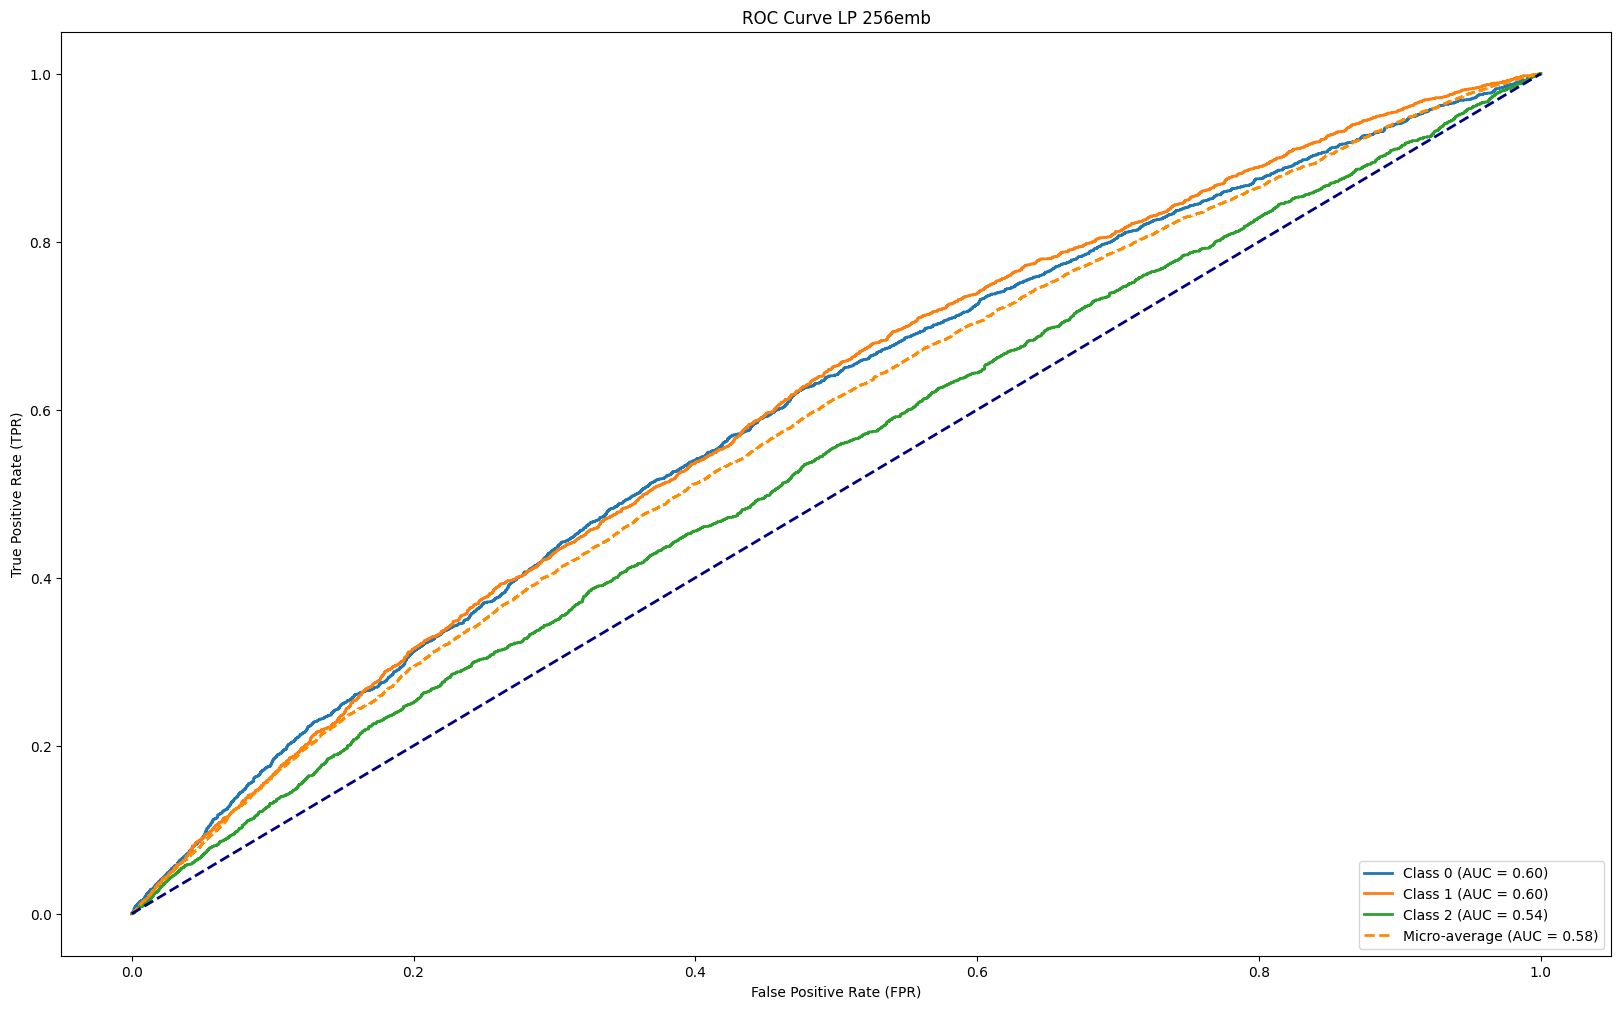

In [ ]:
##ROC AUC

enc_weights_path = "/kaggle/input/weights-ml4sci-all/best_mae_vit_model_256emb_final.pth"
checkpoint = torch.load("/kaggle/working/save_weights/20250323_182415_best.pth")
img_size = 64
encoder = load_pretrained_encoder(enc_weights_path, img_size)
num_classes = 3
device = 'cuda'
new_state_dict = {key.replace("module.", ""): value for key, value in checkpoint.items()}
model = ClassificationModel(encoder, num_classes=3).to(device)
model.load_state_dict(new_state_dict)

model.eval()
num_classes = 3
all_labels = []
all_scores = []

with torch.no_grad():
    for val_inputs, val_labels in test_dataloader:
        val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
        val_outputs = model(val_inputs)
        
        # Assuming the model outputs raw logits, apply softmax to get probabilities
        probabilities = torch.nn.functional.softmax(val_outputs, dim=1)
        
        all_labels.extend(val_labels.cpu().numpy())
        all_scores.extend(probabilities.cpu().numpy())

# Binarize the labels
y_true = label_binarize(all_labels, classes=list(range(num_classes)))

# Ensure y_true and all_scores are numpy arrays
y_true = np.array(y_true)
all_scores = np.array(all_scores)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], all_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), all_scores.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot the ROC curves
plt.figure(figsize=(20, 12))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot(fpr["micro"], tpr["micro"], color='darkorange', linestyle='--', lw=2, label=f'Micro-average (AUC = {roc_auc["micro"]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve LP 256emb')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# # Minimal usage with defaults
# model, history = train_model(model, train_dataloader, test_dataloader)

# # Custom configuration
# criterion = nn.CrossEntropyLoss()
# trainable_params = [p for p in model.parameters() if p.requires_grad]
# optimizer = LARS(
#     trainable_params,
#     lr=0.01,
#     momentum=0.9,
#     weight_decay=1e-4,
#     trust_coefficient=0.001,
#     eps=1e-8
# )
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

# model, history = train_model(
#     model, 
#     train_dataloader, 
#     test_dataloader,
#     criterion=criterion,
#     optimizer=optimizer,
#     scheduler=scheduler,
#     num_epochs=100,
#     save_dir='/kaggle/working/save_weights',
#     experiment_name='LP_classification'
# )

## Full finetuning

In [12]:
!mkdir save_weights

In [ ]:
##Full finetuning was run for 100 epochs. Due to server crash on kaggle
##logs were not saved
##This is the final run just to see train and test acc of the saved model.

criterion = nn.CrossEntropyLoss()
    
# Unfreeze encoder for fine tuning
for param in encoder.parameters():
        param.requires_grad = True


trainable_params = [p for p in model.parameters() if p.requires_grad]


# Define parameter groups
optimizer = torch.optim.AdamW([
    {'params': model.encoder.parameters(), 'lr': 9.5e-5},
    {'params': model.mlp.parameters(), 'lr': 8e-4},
    {'params': model.classifier.parameters(), 'lr': 8e-4}  # Higher LR for classifier
], weight_decay=1e-4)
# Use a cosine learning rate scheduler (common with LARS)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min = 1e-5)  # T_max = number of epochs

# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
NUM_GPU = torch.cuda.device_count()

model = model.to(device)
ckpt = torch.load('/kaggle/working/save_weights/FT_classification.pth')
new_state_dict = {key.replace("module.", ""): value for key, value in ckpt.items()}

model.load_state_dict(new_state_dict)
if NUM_GPU > 1:
    model = nn.DataParallel(model)


total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n ####Total number of train params, training full: {total_params}####")
# Training loop
num_epochs = 50
best_accuracy = 0.0

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    total_train_loss = 0.0
    total_train_correct = 0
    total_train_samples = 0

    train_loader = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} [FT]", leave=True)
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train_samples += labels.size(0)
        total_train_correct += (predicted == labels).sum().item()

        train_loader.set_postfix(loss=loss.item())

    avg_train_loss = total_train_loss / len(train_dataloader)
    train_accuracy = total_train_correct / total_train_samples

    # Validation phase
    model.eval()
    total_val_loss = 0.0
    total_val_correct = 0
    total_val_samples = 0

    val_loader = tqdm(test_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} [Validating]", leave=True)
    
    with torch.no_grad():
        for test_inputs, test_labels in val_loader:
            test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
            test_outputs = model(test_inputs)
            loss = criterion(test_outputs, test_labels)

            total_val_loss += loss.item()
            _, predicted = torch.max(test_outputs, 1)
            total_val_samples += test_labels.size(0)
            total_val_correct += (predicted == test_labels).sum().item()

    avg_val_loss = total_val_loss / len(test_dataloader)
    val_accuracy = total_val_correct / total_val_samples

    # Save best model
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        print(f"\nSaving model at Epoch {epoch+1} with Validation Accuracy: {best_accuracy:.2%}") 
        torch.save(model.state_dict(), '/kaggle/working/save_weights/FT_classification.pth')
    
    # Print training and validation statistics
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2%}, "
          f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2%}")
    
    # Store logs
    train_loss_list.append((epoch, avg_train_loss))
    train_acc_list.append((epoch, train_accuracy))
    val_loss_list.append((epoch, avg_val_loss))
    val_acc_list.append((epoch, val_accuracy))


<ipython-input-11-22ef461d8bc0>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load('/kaggle/working/save_weights/FT_classification.pth')



 ####Total number of train params, training full: 6654211####


Epoch 1/50 [Validating]: 100%|██████████| 18/18 [00:19<00:00,  1.10s/it]



Saving model at Epoch 1 with Validation Accuracy: 46.74%
Epoch 1/50 - Train Loss: 0.3537, Train Accuracy: 85.15%, Validation Loss: 2.1744, Validation Accuracy: 46.74%


Epoch 2/50 [Validating]: 100%|██████████| 18/18 [00:11<00:00,  1.61it/s]



Saving model at Epoch 2 with Validation Accuracy: 69.31%
Epoch 2/50 - Train Loss: 0.3352, Train Accuracy: 85.83%, Validation Loss: 0.9173, Validation Accuracy: 69.31%


Epoch 3/50 [Validating]: 100%|██████████| 18/18 [00:11<00:00,  1.51it/s]



Saving model at Epoch 3 with Validation Accuracy: 70.93%
Epoch 3/50 - Train Loss: 0.3358, Train Accuracy: 85.63%, Validation Loss: 0.9722, Validation Accuracy: 70.93%


Epoch 4/50 [Validating]: 100%|██████████| 18/18 [00:10<00:00,  1.66it/s]



Saving model at Epoch 4 with Validation Accuracy: 82.26%
Epoch 4/50 - Train Loss: 0.3358, Train Accuracy: 85.65%, Validation Loss: 0.4639, Validation Accuracy: 82.26%


Epoch 5/50 [Validating]: 100%|██████████| 18/18 [00:11<00:00,  1.63it/s]0.326]


Epoch 5/50 - Train Loss: 0.3331, Train Accuracy: 85.88%, Validation Loss: 0.4589, Validation Accuracy: 80.28%


Epoch 6/50 [Validating]: 100%|██████████| 18/18 [00:10<00:00,  1.66it/s]


Epoch 6/50 - Train Loss: 0.3329, Train Accuracy: 85.92%, Validation Loss: 0.4205, Validation Accuracy: 81.72%


Epoch 7/50 [Validating]: 100%|██████████| 18/18 [00:11<00:00,  1.62it/s]


Epoch 7/50 - Train Loss: 0.3295, Train Accuracy: 86.14%, Validation Loss: 0.8103, Validation Accuracy: 75.37%


Epoch 8/50 [Validating]: 100%|██████████| 18/18 [00:11<00:00,  1.63it/s]


Epoch 8/50 - Train Loss: 0.3263, Train Accuracy: 86.33%, Validation Loss: 0.5047, Validation Accuracy: 78.71%


Epoch 9/50 [Validating]: 100%|██████████| 18/18 [00:11<00:00,  1.62it/s]


Epoch 9/50 - Train Loss: 0.3378, Train Accuracy: 85.74%, Validation Loss: 0.9132, Validation Accuracy: 72.85%


Epoch 10/50 [Validating]: 100%|██████████| 18/18 [00:10<00:00,  1.74it/s]


Epoch 10/50 - Train Loss: 0.3228, Train Accuracy: 86.28%, Validation Loss: 0.6003, Validation Accuracy: 75.54%


Epoch 11/50 [Validating]: 100%|██████████| 18/18 [00:10<00:00,  1.67it/s]



Saving model at Epoch 11 with Validation Accuracy: 83.21%
Epoch 11/50 - Train Loss: 0.3256, Train Accuracy: 86.15%, Validation Loss: 0.3962, Validation Accuracy: 83.21%


Epoch 12/50 [Validating]: 100%|██████████| 18/18 [00:10<00:00,  1.77it/s]


Epoch 12/50 - Train Loss: 0.3223, Train Accuracy: 86.40%, Validation Loss: 1.3906, Validation Accuracy: 58.18%


Epoch 13/50 [Validating]: 100%|██████████| 18/18 [00:10<00:00,  1.72it/s]


Epoch 13/50 - Train Loss: 0.3272, Train Accuracy: 86.17%, Validation Loss: 1.4950, Validation Accuracy: 51.96%


Epoch 14/50 [Validating]: 100%|██████████| 18/18 [00:10<00:00,  1.72it/s]


Epoch 14/50 - Train Loss: 0.3217, Train Accuracy: 86.40%, Validation Loss: 1.8226, Validation Accuracy: 60.41%


Epoch 15/50 [Validating]: 100%|██████████| 18/18 [00:10<00:00,  1.78it/s]


Epoch 15/50 - Train Loss: 0.3167, Train Accuracy: 86.63%, Validation Loss: 1.6199, Validation Accuracy: 62.66%


Epoch 16/50 [Validating]: 100%|██████████| 18/18 [00:11<00:00,  1.61it/s]


Epoch 16/50 - Train Loss: 0.3108, Train Accuracy: 86.80%, Validation Loss: 0.4238, Validation Accuracy: 82.30%


Epoch 17/50 [Validating]: 100%|██████████| 18/18 [00:11<00:00,  1.62it/s]



Saving model at Epoch 17 with Validation Accuracy: 83.77%
Epoch 17/50 - Train Loss: 0.3142, Train Accuracy: 86.72%, Validation Loss: 0.3949, Validation Accuracy: 83.77%


Epoch 18/50 [Validating]: 100%|██████████| 18/18 [00:11<00:00,  1.61it/s]


Epoch 18/50 - Train Loss: 0.3105, Train Accuracy: 86.87%, Validation Loss: 0.9737, Validation Accuracy: 71.53%


Epoch 19/50 [Validating]: 100%|██████████| 18/18 [00:11<00:00,  1.59it/s]


Epoch 19/50 - Train Loss: 0.3067, Train Accuracy: 86.92%, Validation Loss: 0.5630, Validation Accuracy: 75.00%


Epoch 20/50 [Validating]: 100%|██████████| 18/18 [00:10<00:00,  1.69it/s]



Saving model at Epoch 20 with Validation Accuracy: 85.07%
Epoch 20/50 - Train Loss: 0.3064, Train Accuracy: 87.09%, Validation Loss: 0.3800, Validation Accuracy: 85.07%


Epoch 21/50 [Validating]: 100%|██████████| 18/18 [00:11<00:00,  1.56it/s]



Saving model at Epoch 21 with Validation Accuracy: 85.92%
Epoch 21/50 - Train Loss: 0.3074, Train Accuracy: 87.09%, Validation Loss: 0.3553, Validation Accuracy: 85.92%


Epoch 22/50 [Validating]: 100%|██████████| 18/18 [00:11<00:00,  1.61it/s]


Epoch 22/50 - Train Loss: 0.2990, Train Accuracy: 87.24%, Validation Loss: 0.3412, Validation Accuracy: 85.57%


Epoch 23/50 [Validating]: 100%|██████████| 18/18 [00:09<00:00,  1.81it/s]


Epoch 23/50 - Train Loss: 0.3079, Train Accuracy: 86.98%, Validation Loss: 2.1356, Validation Accuracy: 58.78%


Epoch 24/50 [Validating]: 100%|██████████| 18/18 [00:10<00:00,  1.71it/s]


Epoch 24/50 - Train Loss: 0.3035, Train Accuracy: 87.19%, Validation Loss: 0.8524, Validation Accuracy: 69.25%


Epoch 25/50 [Validating]: 100%|██████████| 18/18 [00:11<00:00,  1.62it/s]


Epoch 25/50 - Train Loss: 0.3064, Train Accuracy: 87.13%, Validation Loss: 1.1710, Validation Accuracy: 69.33%


Epoch 26/50 [Validating]: 100%|██████████| 18/18 [00:10<00:00,  1.71it/s]


Epoch 26/50 - Train Loss: 0.2992, Train Accuracy: 87.26%, Validation Loss: 0.4552, Validation Accuracy: 82.22%


Epoch 27/50 [Validating]: 100%|██████████| 18/18 [00:10<00:00,  1.74it/s]



Saving model at Epoch 27 with Validation Accuracy: 86.40%
Epoch 27/50 - Train Loss: 0.3038, Train Accuracy: 87.07%, Validation Loss: 0.3153, Validation Accuracy: 86.40%


Epoch 28/50 [Validating]: 100%|██████████| 18/18 [00:10<00:00,  1.72it/s]


Epoch 28/50 - Train Loss: 0.3076, Train Accuracy: 87.08%, Validation Loss: 0.3828, Validation Accuracy: 84.38%


Epoch 29/50 [FT]:   4%|▍         | 7/157 [00:06<02:11,  1.14it/s, loss=0.322]


KeyboardInterrupt: 

<ipython-input-15-c3e7db48446f>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/kaggle/input/weights-ml4sci-all/FT_classification_final_256emb.pth

Missing keys: []
Unexpected keys: ['decoder.mask_token', 'decoder.decoder_pos_embed', 'decoder.decoder_embed.weight', 'decoder.decoder_embed.bias', 'decoder.decoder_blocks.0.norm1.weight', 'decoder.decoder_blocks.0.norm1.bias', 'decoder.decoder_blocks.0.attn.qkv.weight', 'decoder.decoder_blocks.0.attn.qkv.bias', 'decoder.decoder_blocks.0.attn.proj.weight', 'decoder.decoder_blocks.0.attn.proj.bias', 'decoder.decoder_blocks.0.norm2.weight', 'decoder.decoder_blocks.0.norm2.bias', 'decoder.decoder_blocks.0.mlp.fc1.weight', 'decoder.decoder_blocks.0.mlp.fc1.bias', 'decoder.decoder_blocks.0.mlp.fc2.weight', 'decoder.decoder_blocks.0.mlp.fc2.bias', 'decoder.decoder_blocks.1.norm1.weight', 'decoder.decoder_blocks.1.norm1.bias', 'decoder.decoder_blocks.1.attn.qkv.weight', 'decoder.decoder_blocks.1.attn.qkv.bias', 'decoder.decoder_blocks.1.attn.proj.weight', 'decoder.decoder_blocks.1.attn.proj.bias', 'decoder.decoder_blocks.1.norm2.weight', 'decoder.decoder_blocks.1.norm2.bias', 'decoder.decoder

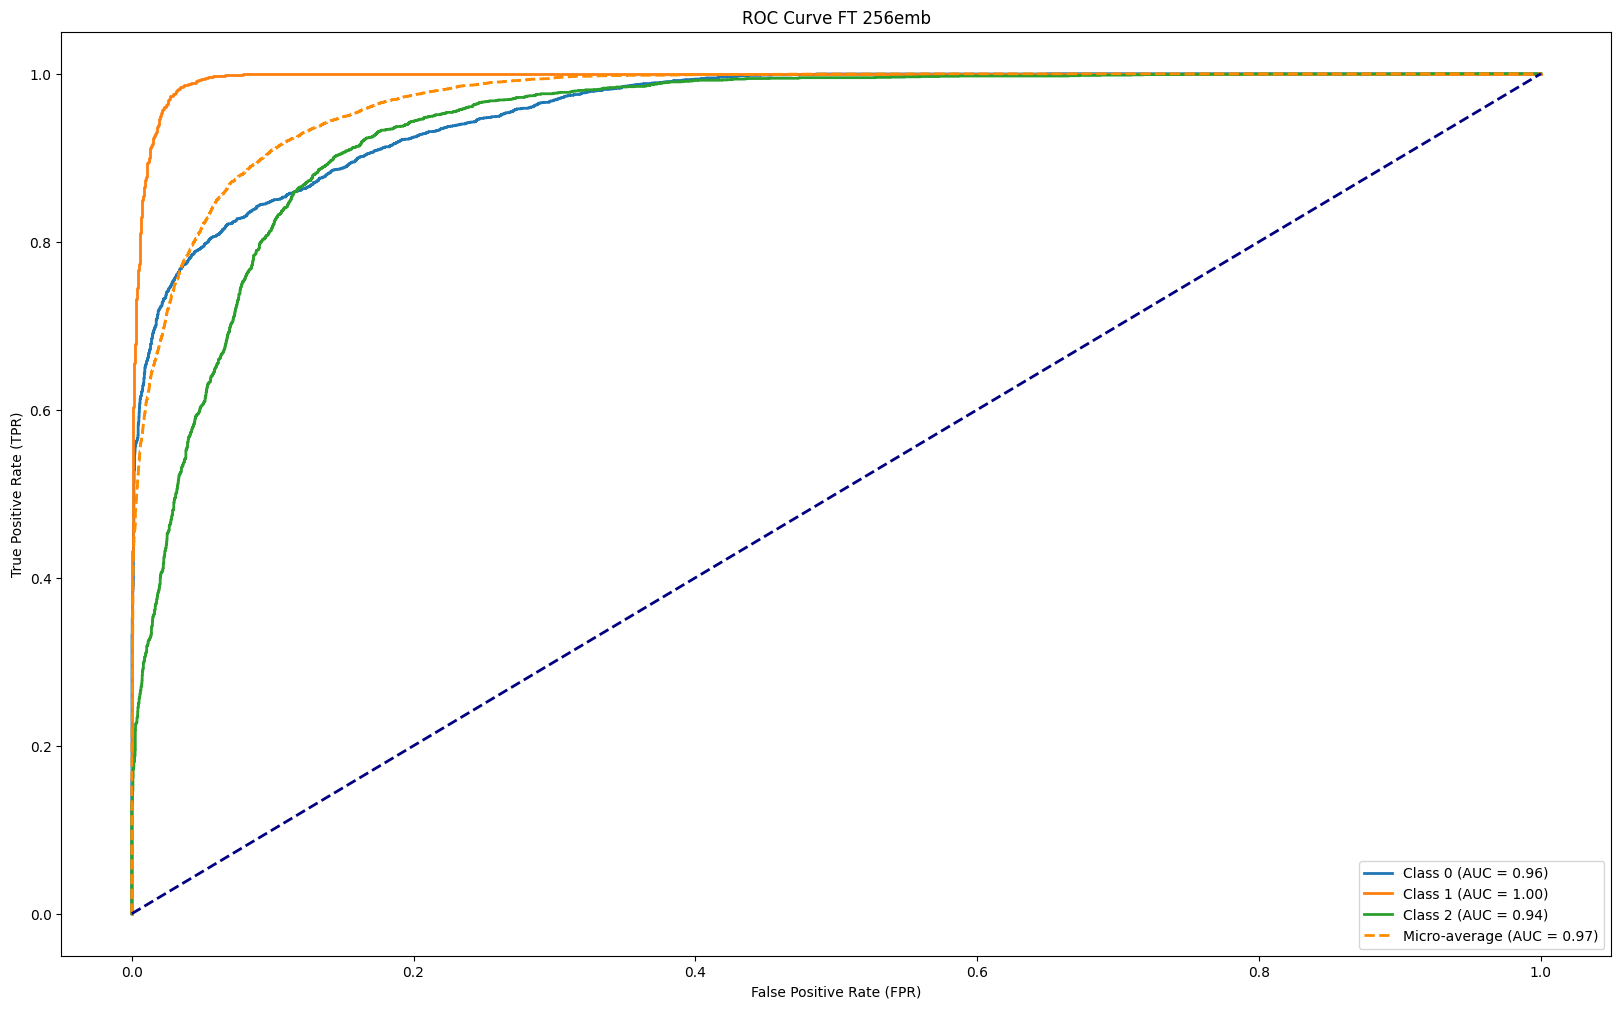

In [15]:
##ROC AUC
enc_weights_path = "/kaggle/input/weights-ml4sci-all/best_mae_vit_model_256emb_final.pth"
checkpoint = torch.load("/kaggle/input/weights-ml4sci-all/FT_classification_final_256emb.pth", map_location = 'cpu')
img_size = 64
encoder = load_pretrained_encoder(enc_weights_path, img_size)
num_classes = 3
device = 'cpu'
new_state_dict = {key.replace("module.", ""): value for key, value in checkpoint.items()}
model = ClassificationModel(encoder, num_classes=3).to(device)
model.load_state_dict(new_state_dict)

model.eval()
num_classes = 3
all_labels = []
all_scores = []

with torch.no_grad():
    for val_inputs, val_labels in test_dataloader:
        val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
        val_outputs = model(val_inputs)
        
        # Assuming the model outputs raw logits, apply softmax to get probabilities
        probabilities = torch.nn.functional.softmax(val_outputs, dim=1)
        
        all_labels.extend(val_labels.cpu().numpy())
        all_scores.extend(probabilities.cpu().numpy())

# Binarize the labels
y_true = label_binarize(all_labels, classes=list(range(num_classes)))

# Ensure y_true and all_scores are numpy arrays
y_true = np.array(y_true)
all_scores = np.array(all_scores)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], all_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), all_scores.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot the ROC curves
plt.figure(figsize=(20, 12))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot(fpr["micro"], tpr["micro"], color='darkorange', linestyle='--', lw=2, label=f'Micro-average (AUC = {roc_auc["micro"]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve FT 256emb')
plt.legend(loc="lower right")
plt.show()
